[INFO] loading images...
['coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'coast', 'c

<Figure size 640x480 with 0 Axes>

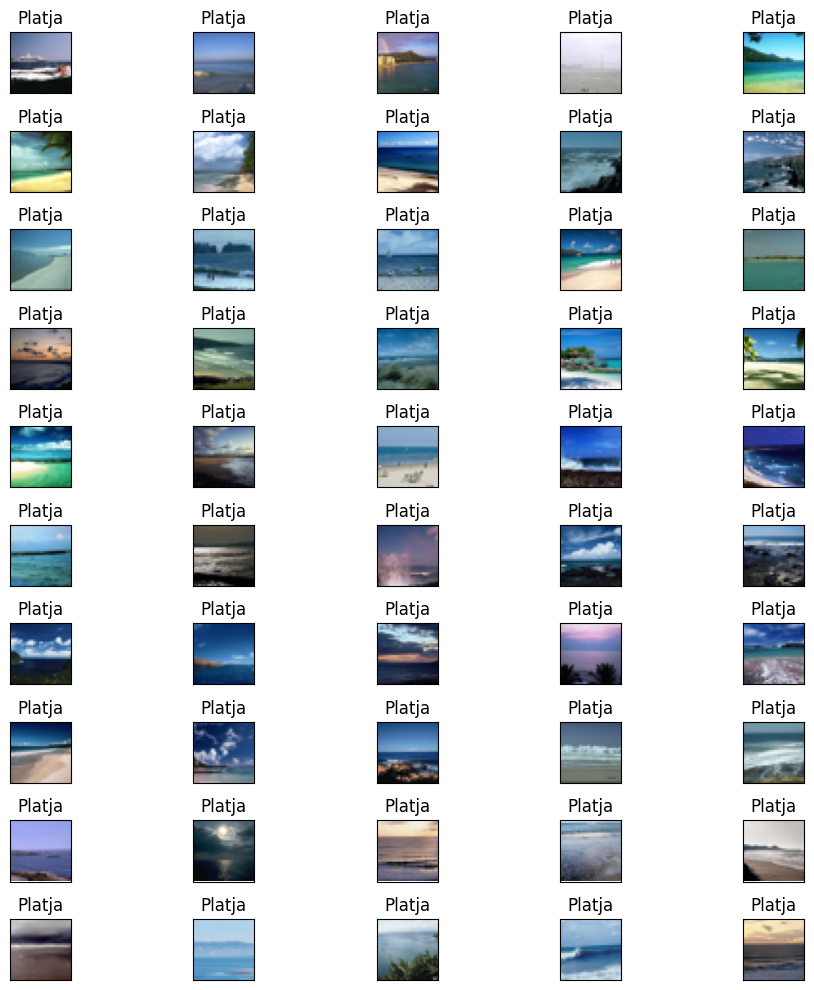

In [72]:
# Classificador de 3scenes mitjançant Deep Learning. Fa servir xarxes neuronals convolucionades

# import the necessary packages
import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Activation
from keras.layers import Flatten
from keras.layers import Dense
from keras.optimizers import Adam
from keras import backend as K
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from PIL import Image
from imutils import paths
import numpy as np
import argparse
import os
import matplotlib.pyplot as plt

dataset = "3scenes"

# Agafa totes les imatges del dataset i les classifica
print("[INFO] loading images...")
imagePaths = paths.list_images(dataset)
data = []
labels = []
nom_paissatge=['Platja','Bosc','Carretera']
# bucle sobre les imatges
for imagePath in imagePaths:
	# carrega la imatge, la reescala a 32x32. Compte. Això es perque vagi més rapid pero evidentment perjudicarà la prediccio.
	# remapeja l'intensistat del pixel del minim al maxim (per a que quedi mes diferenciada)

	image = Image.open(imagePath)
	image = np.array(image.resize((32, 32))) / 255.0
	data.append(image)

	# Treu l'etiqueta del path (es a dir, l'etiqueta es el nom de la carpeta)
	label = imagePath.split(os.path.sep)[-2]
	labels.append(label)

print(labels)

# codifica les etiquetes a enters
lb = LabelBinarizer()

labels = lb.fit_transform(labels)
print(labels)
plt.subplots_adjust(hspace=2, wspace=1)
fig = plt.figure(figsize=(10, 10))

for a in range(50):
	#subplot per imprimir una imatge al costat d'una altra
    plt.subplot(10,5, a+1)
    plt.xticks([])
    plt.yticks([])
    # Per veure amb l'scala de grisos cmap
    plt.imshow(data[a],cmap=plt.cm.binary)
    #plt.xlabel(nom_paissatge[np.argmax(labels[a])])
    plt.title(nom_paissatge[np.argmax(labels[a])])
    #plt.text(0.5, -0.25, nom_paissatge[np.argmax(labels[a])], ha="center", transform=plt.gca().transAxes)
plt.tight_layout()
plt.show()



In [73]:

# Carrega el dataset i el divideix en dos datasets aleatoriament
# Fa servir 3/4 per training i 1/4 per avaluació
(trainX, testX, trainY, testY) = train_test_split(np.array(data),
	np.array(labels), test_size=0.25)

#ACTIVAR AQUESTES DUES LINIES EN CAS DE QUE EL CLASIFICADOR SIGUI BINARI (NOMES 2 OPCIONS)
#trainY = to_categorical(trainY)
#testY = to_categorical(testY)

#Que definim nosaltres:
#1. Cuantes capes
#2. Cuantes neurones per capa
#3. Tipus de capa

# defineix la CNN
model = Sequential()
#Primera capa, de 8. aquesta es una capa d'input a on li entren els 32*32 pixels de l'imatge
#Tipus de capes que hi ha.
#Conv - Convolucional. Cuando estas asociado con el vecino. Hay de varias dimensiones
#Dense - Los datos estan relacionados pero no hay una relacion en que algunos estan mas relacionados que otros
#Dropout y Flatten
#Kerneling - el Kernel se aplica solo en las conv. crea una matriz alrededor del punto central. Es decir, en vez de analizar pixel a pixel, analiza grupos de 3x3 pixel
model.add(Conv2D(8, (3, 3), padding="same", input_shape=(32, 32, 3)))
#funcio d'activació. determina com de "segur" ha d'estar per a tornar 1.
model.add(Activation("elu"))
#El max pooling serveix per que la xarxa no quedi inmensa i tardi anys
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#Segona capa, de 16, intermitja. el 3,3 es la mida del kernel (mesura cada pixel en relacio als pixels dels costats)
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("elu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#Tercera capa, de 32. Sol ser bona idea que cada capa sigui el doble de l'anterior. Pero no sempre, aixi es el ML
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("elu"))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))


#Cuarta capa. Why not
#model.add(Conv2D(64, (5, 5), padding="same"))
#model.add(Activation(keras.layers.LeakyReLU(alpha=0.3)))
#model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
#Afegeix una capa final de 3, amb un classificador softmax (donarà output i serà amb percentatges de probabilitat)
model.add(Flatten())
model.add(Dense(3))
model.add(Activation("softmax"))

# Inicialitza l'optimitzador i model d'entrenament
print("[INFO] training network...")
# Adam es un bon optimitzador per CNN, pero no sempre el millor.

learning_rate = keras.optimizers.schedules.ExponentialDecay(
initial_learning_rate=1e-3, decay_steps=20, decay_rate=1e-3 / 50)

opt = Adam(learning_rate=learning_rate)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
# Entrenament. Aqui has d'indicar cuantes "epoques" (generacions) vols entrenar l'algoritme.
H = model.fit(trainX, trainY, validation_data=(testX, testY),
	epochs=20, batch_size=2)

# avaluació

##dates sobre el model de train
print("[INFO] evaluating network over training data...")
predictions = model.predict(trainX, batch_size=32)
print(classification_report(trainY.argmax(axis=1),
    predictions.argmax(axis=1), target_names=lb.classes_))

##dates sobre el model de test
print("[INFO] evaluating network over validation data...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
    predictions.argmax(axis=1), target_names=lb.classes_))

#mirar si son molt diferents i explicar overfitting i underfitting

[INFO] training network...
Epoch 1/20
356/356 [==============================] - 3s 6ms/step - loss: 1.1466 - accuracy: 0.3713 - val_loss: 1.1888 - val_accuracy: 0.3629
Epoch 2/20
356/356 [==============================] - 2s 5ms/step - loss: 1.1432 - accuracy: 0.3741 - val_loss: 1.1888 - val_accuracy: 0.3629
Epoch 3/20
356/356 [==============================] - 2s 6ms/step - loss: 1.1432 - accuracy: 0.3741 - val_loss: 1.1888 - val_accuracy: 0.3629
Epoch 4/20
356/356 [==============================] - 2s 5ms/step - loss: 1.1432 - accuracy: 0.3741 - val_loss: 1.1888 - val_accuracy: 0.3629
Epoch 5/20
356/356 [==============================] - 2s 6ms/step - loss: 1.1432 - accuracy: 0.3741 - val_loss: 1.1888 - val_accuracy: 0.3629
Epoch 6/20
356/356 [==============================] - 2s 5ms/step - loss: 1.1432 - accuracy: 0.3741 - val_loss: 1.1888 - val_accuracy: 0.3629
Epoch 7/20
356/356 [==============================] - 2s 6ms/step - loss: 1.1432 - accuracy: 0.3741 - val_loss: 1.1888 - 

d:\documents\m6\curs ml\pycharm\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\documents\m6\curs ml\pycharm\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\documents\m6\curs ml\pycharm\venv\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\documents\m6\cur

Platja
Bosc


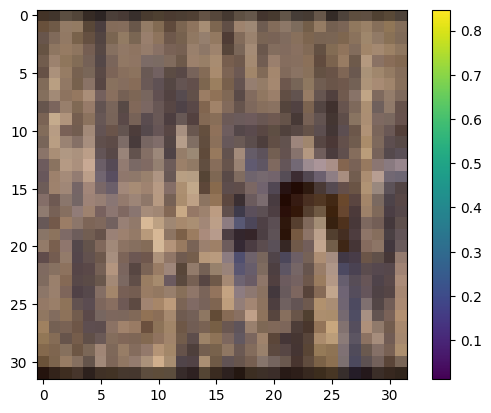

Platja
Bosc


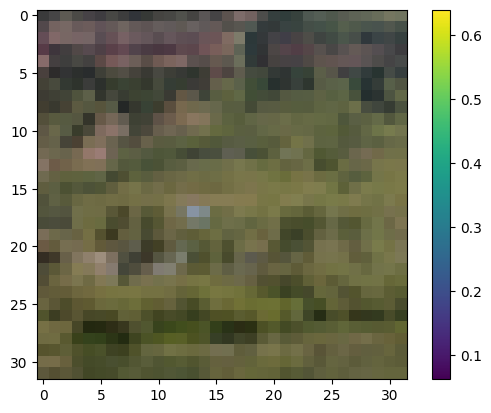

Llista de diferències
237
Platja
Bosc
Platja
Bosc
Platja
Carretera
Platja
Carretera
Platja
Carretera
Platja
Bosc
Platja
Bosc
Platja
Carretera
Platja
Bosc
Platja
Bosc
Platja
Carretera
Platja
Bosc
Platja
Bosc
Platja
Carretera
Platja
Bosc
Platja
Carretera
Platja
Bosc
Platja
Carretera
Platja
Bosc
Platja
Bosc
Platja
Carretera
Platja
Carretera
Platja
Bosc
Platja
Bosc
Platja
Carretera
Platja
Bosc
Platja
Carretera
Platja
Bosc
Platja
Carretera
Platja
Carretera
Platja
Bosc
Platja
Bosc
Platja
Bosc
Platja
Bosc
Platja
Bosc
Platja
Bosc
Platja
Bosc
Platja
Carretera
Platja
Carretera
Platja
Bosc
Platja
Bosc
Platja
Bosc
Platja
Bosc
Bosc
Platja
Platja
Bosc
Platja
Bosc
Platja
Carretera
Platja
Bosc
Platja
Carretera
Platja
Bosc
Platja
Carretera
Platja
Bosc
Platja
Carretera
Platja
Bosc
Platja
Bosc
Platja
Carretera
Platja
Carretera
Platja
Bosc
Platja
Carretera
Bosc
Carretera
Platja
Bosc
Platja
Carretera
Platja
Bosc
Platja
Carretera
Platja
Bosc
Platja
Carretera
Platja
Carretera
Platja
Bosc
Platja
Bosc
Platja
B

In [74]:
print(nom_paissatge[np.argmax(predictions[0])])
print(nom_paissatge[np.argmax(testY[0])])

plt.figure()
plt.imshow(testX[0])
plt.colorbar()
plt.grid(False)
plt.show();

print(nom_paissatge[np.argmax(predictions[1])])
print(nom_paissatge[np.argmax(testY[1])])

plt.figure()
plt.imshow(testX[1])
plt.colorbar()
plt.grid(False)
plt.show();

print("Llista de diferències")

print(len(predictions))
count=0
for i in range(len(predictions)):
	if nom_paissatge[np.argmax(predictions[i])] != nom_paissatge[np.argmax(testY[i])]:
		count+=1
		print(nom_paissatge[np.argmax(predictions[i])])
		print(nom_paissatge[np.argmax(testY[i])])

		'''plt.figure()
		plt.imshow(testX[i])
		plt.colorbar()
		plt.grid(False)
		plt.show();
		'''

print("El total de diferències és:", str(count))
